# Uso
Para ejecutar todo el Notebook, arriba en el menu:
    Cell > RunAll
## SIR España 

Parametros a cambiar 

- initDay : dia inicial desde el cual queremos que empiece el ajuste 
- day : Numero de dias desde initDay para ajustar, en caso de que el numero de dias sea mayor que el numero de datos del que disponemos a partir de initDay se recogeran solo los datos                 reales hasta el final
- yearsFuture : Numero de años a visualizar con los parametros beta y gamma obtenidos
- predictionNumber : Numero de dias de prediccion a simular 
- export2Tex : True si se quiere exportar a Latex, caso contrario False

    

# Parametros a cambiar

In [1]:
'''
* initDay : Dia Inicial desde donde queremos predecir
* day : Cuantos dias desde `initDay` cortamos 
* yearsFuture : Numero de años a visualizar con los parametros beta y gamma obtenidos
'''
initDay = 0
day=15
yearsFuture = 0.333


'''
* predictionNumber : el numero de dias que queremos predecir desde `initDay + day` 
'''
predictionNumber = 5

simulacionFuturo=True
'''
* export2Tex : Si quieres documento en latex (True), caso contrario (False)
'''
export2Tex = True


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate,optimize
from processingModule import getCities
import tikzplotlib
import os

plt.style.use("seaborn")
%matplotlib inline

In [3]:
def toLatex(name:str,export2Tex=False):
    if not os.path.exists('latex'):
        os.makedirs('latex')
    if(export2Tex):
        tikzplotlib.clean_figure()
        tikzplotlib.save(f"./latex/{name}.tex")

# SIR Model

In [4]:
'''
Modelo SIR - Simplificado
* y : funciones S(t),I(t),R(t)
* t : Espacio de partida - tiempo
* Args : Beta & Gamma - Parametros SIR
'''
def SIR(y,t,beta,gamma):
    S,I,R = y
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return dS,dI,dR

'''
Modelo SIR - Con parametro de muertes
* y : funciones S(t),I(t),R(t)
* t : Espacio de partida - tiempo
* Args : Beta, Gamma & mu - Parametros SIR
'''
def SIR2(y,t,beta,gamma,mu):
    S,I,R = y
    dS = -beta * S * I/N + mu*(N-S)
    dI = beta * S * I/N -gamma*I-mu*I
    dR = gamma * I - mu*R
    return dS,dI,dR

# RSS - Residuos

In [5]:
'''
Funcion resiuduos
* Values = beta & gamma 
* Devuelve la suma de las diferencia al cuadrado, entre los datos reales y los predichos
'''
def functionRSS(values):
    beta, gamma = values
    # print(f'Called with \n\tBeta:{beta}\tGamma:{gamma}')
    infectius = integrate.odeint(SIR,(S0,I0,R0),xData,args=(beta,gamma))[:,1]
    residues = np.array([ (yData[i]-infectius[i]) for i in range(0,len(infectius)) ]) 
    return np.sum(np.power(residues,2))
'''
Funcion resiuduos
* Values = beta, gamma & mu
* Devuelve la suma de las diferencia al cuadrado, entre los datos reales y los predichos
'''
def functionRSS2(values):
    beta, gamma,mu = values
    # print(f'Called with \n\tBeta:{beta}\tGamma:{gamma}')
    infectius = integrate.odeint(SIR2,(S0,I0,R0),xData,args=(beta,gamma,mu))[:,1]
    residues = np.array([ (yData[i]-infectius[i]) for i in range(0,len(infectius)) ]) 
    return np.sum(np.power(residues,2))

# MODELADO

## Caso Real

### Valores Obtenidos

In [6]:
'''
Cojemos Datos y tomamos el primer valor que tiene infectados > 0
'''
try:
    city = getCities()["Spain"]
except Exception:
    city = getCities(True)["Spain"]
    
xData_Date = []
yData = []
first = 0
for i in city:
    if(i[1]>0):
        first +=1
    if(first>0):
        xData_Date.append(i[0])
        yData.append(i[1])
xData = [i for i in range(1,len(xData_Date)+1)]

Everything in order


In [7]:
'''
* allRecovered : Recuperados acumulados - a partir del `inicio-15` todos los infectados acumulados
'''
allRecovered = 0
if(initDay>15):
    allRecovered = np.sum(xData[0:initDay-15])


In [8]:
'''
Tomamos dos espacios de partida
'''
# Espacio de prediccion
xDataPred = xData[initDay:initDay+day]
xDataPred = np.append(xDataPred,[i for i in range(xDataPred[len(xDataPred)-1] + 1, xDataPred[len(xDataPred)-1] +1 +predictionNumber)]) #+1 para no añadir dos veces el ult elemento ya que lo añadi antes

#si nos pasamos de tamaño total hay que añadir 0's y sino cojo los datos reales
if(initDay + day + predictionNumber < len(yData)):
    yDataPred = yData[initDay:initDay+day+predictionNumber] #cojo todos los datos reales
else:
    simulacionFuturo=True
    yDataPred = yData[initDay: initDay + day] #cojo los datos que haya reales
    yDataPred = np.append(yDataPred, np.zeros(predictionNumber, dtype=int)) #concateno un numero de 0's

# Espacio a minimizar residuos
xData=xData[initDay:initDay+day]
yData=yData[initDay:initDay+day]

yData = np.array(yData, dtype=int)
xData = np.array(xData, dtype=int)

### Condiciones Iniciales

In [9]:
'''
CONDICIONES INICIALES : 
    - N : Tamaño poblacion inicial
    - I0 : Infectados Iniciales
    - S0 : Susceptibles Iniciales
'''
N = 46700000
I0 = yData[0]
R0 = allRecovered
S0 = N-I0-R0

### Obtenemos Beta y Gamma

In [10]:
'''
Minimizamos los residuos en base a la funcion de residuos especifica
'''
# Optimizamos la funcion de residuos con el SIR basico
res = optimize.minimize(functionRSS,[0.5,0.5],bounds=[(0,1),(0,1)])
beta, gamma = res.x
# Optimizamos la funcion de residuos con el SIR con muertes
res2 = optimize.minimize(functionRSS2,[0.5,0.5,0.1],bounds=[(0,1),(0,1),(0,1)])
beta2,gamma2, mu2 = res2.x
# Sacamos los valores obtenidos
print(f"Beta: {res.x[0]} \tGamma:{res.x[1]}\tR0={res.x[0]/res.x[1]}")
print(f"Beta: {res2.x[0]} \tGamma:{res2.x[1]}\tMu:{res2.x[2]}\tR0={res2.x[0]/res2.x[1]}")

Beta: 0.7000288333397645 	Gamma:0.2999711586331863	R0=2.3336537970164684
Beta: 0.7272988952868362 	Gamma:0.2727011015415785	Mu:0.05454021849121015	R0=2.667018545856316


In [11]:
'''
Usando el espacio de predicciones - espacio a minimizar + continuacion datos, calculamos los valores
'''
resultFunctions = integrate.odeint(SIR, (S0, I0, R0), xDataPred, args=(beta, gamma))
resultFunctions2 = integrate.odeint(SIR2, (S0, I0, R0), xDataPred, args=(beta2, gamma2,mu2))


In [12]:
'''
Acumulamos los infectados y lo comparamos con las prediciones
'''
acumulativeInfectiusReal = []
acumulativeInfectius = []
acumulativeInfectius2 = []
for i in range(0,len(yDataPred)):
    if(i==0):
        acumulativeInfectiusReal.append(yDataPred[0])
        acumulativeInfectius.append(resultFunctions[0,1])
        acumulativeInfectius2.append(resultFunctions2[0,1])
    else:
        if(yDataPred[i] == 0):
            acumulativeInfectiusReal.append(0)
        else:
            acumulativeInfectiusReal.append(acumulativeInfectiusReal[i-1]+yDataPred[i])
        acumulativeInfectius.append(acumulativeInfectius[i-1]+resultFunctions[i,1])
        acumulativeInfectius2.append(acumulativeInfectius2[i-1]+resultFunctions2[i,1])


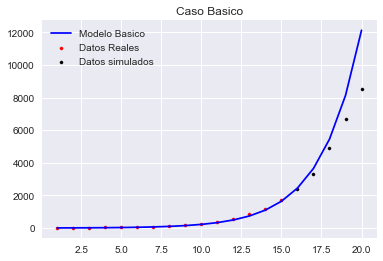

In [13]:
'''
Enfrentamos el modelo SIR basico con los datos reales y vemos si se predice correctamente
'''
plt.figure("Caso Basico")
plt.title("Caso Basico")
plt.plot(xDataPred,acumulativeInfectius,"b")

if(not simulacionFuturo):
    plt.scatter(xData, acumulativeInfectiusReal[:len(xData)], c="red",s=10)
    plt.legend(["Modelo Basico","Datos Reales"])

else:
    plt.scatter(xData, acumulativeInfectiusReal[:len(xData)], c="red",s=10)
    plt.scatter(xDataPred[len(xData):], acumulativeInfectiusReal[len(xData):], c="black",s=10)
    plt.legend(["Modelo Basico","Datos Reales", "Datos simulados"])


toLatex("Muertes Acumuladas - Caso Basico",export2Tex)
plt.show()

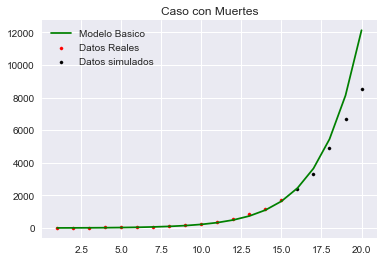

In [14]:
'''
Enfrentamos el modelo SIR - con muertes - con los datos reales y vemos si se predice correctamente
'''
plt.figure("Caso con muertes")
plt.title("Caso con Muertes")
plt.plot(xDataPred,acumulativeInfectius2,"g")

if(not simulacionFuturo):
    plt.scatter(xData, acumulativeInfectiusReal[:len(xData)], c="red",s=10)
    plt.legend(["Modelo Basico","Datos Reales"])

else:
    plt.scatter(xData, acumulativeInfectiusReal[:len(xData)], c="red",s=10)
    plt.scatter(xDataPred[len(xData):], acumulativeInfectiusReal[len(xData):], c="black",s=10)
    plt.legend(["Modelo Basico","Datos Reales", "Datos simulados"])

toLatex("Muertes Acumuladas - Caso Muertes",export2Tex)
plt.show()

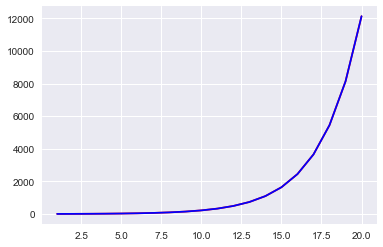

In [15]:
'''
Comparamos ambas graficas
'''
plt.plot(xDataPred,acumulativeInfectius2,"r")
plt.plot(xDataPred,acumulativeInfectius,"b")
plt.show()

### Plot

In [16]:
'''
Damos una vision global en base a los parametros obtenidos anteriormente
'''


predict = np.linspace(0.0,int(365*yearsFuture),num=int(365*yearsFuture))
resultFunctions = integrate.odeint(SIR, (S0, I0, R0), predict, args=(beta, gamma))
resultFunctions2 = integrate.odeint(SIR2, (S0, I0, R0), predict, args=(beta2, gamma2,mu2))

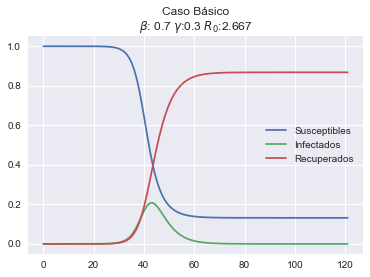

In [17]:
'''
Caso basico 
'''
plt.figure("Caso Basico")
plt.title(f"Caso Básico\n$\\beta$: {round(beta,3)} $\gamma$:{round(gamma,3)} $R_0$:{round(beta2/gamma2,3)}")
plt.plot(predict, resultFunctions[:,0]/N)
plt.plot(predict, resultFunctions[:,1]/N)
plt.plot(predict, resultFunctions[:,2]/N)
plt.legend(["Susceptibles","Infectados","Recuperados"])
toLatex("CasoBasico - España",export2Tex)
plt.show()

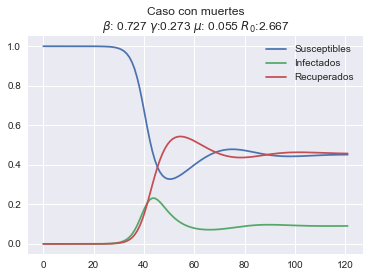

In [18]:
'''
Caso con muertes 
'''
plt.figure("Caso con muertes")
plt.title(f"Caso con muertes\n$\\beta$: {round(beta2,3)} $\gamma$:{round(gamma2,3)} $\mu$: {round(mu2,3)} $R_0$:{round(beta2/gamma2,3)}")
plt.plot(predict, resultFunctions2[:,0]/N)
plt.plot(predict, resultFunctions2[:,1]/N)
plt.plot(predict, resultFunctions2[:,2]/N)
plt.legend(["Susceptibles","Infectados","Recuperados"])
toLatex("CasoMuertes - España",export2Tex)
plt.show()